In [53]:
import copy
import math
import matplotlib.pyplot as plt
import os
import re
import subprocess
import sys
import pandas as pd
import pickle
import time

from ast import literal_eval
from matplotlib.ticker import FuncFormatter
from IPython.display import display, clear_output

In [31]:
# pull in our gquery module and import the config
sys.path.append('../../scripts')
os.environ['GUFI_CONFIG']='/home/jbent/GUFI/configs/jbent_home'
#os.environ['GUFI_DEBUG']='TRUE'
import gufi_config as gq
import gufi_common as gc

config = open(os.environ['GUFI_CONFIG'], 'r')
config=gq.Server(config)

nthreads=config.config['Threads']
indexroot=config.config['IndexRoot']
print(f"Using {nthreads} threads on {indexroot}")

Using 224 threads on /mnt/nvme3n1/jbent/jbent_home


In [83]:
def run_gufi_query(indexroot, nthreads, create_int, insert_int, create_agg, insert_agg, select_agg, Verbose=False):
    cmd = 'gufi_query'
    command = [
        cmd,
        "-B", "4096",
        "-I", create_int,
        "-S", insert_int,
        "-K", create_agg,
        "-J", insert_agg,
        "-G", select_agg,
        "-n", nthreads,
        indexroot
    ]
    if Verbose:
        gc.print_query(command)
    
    start_time = time.time()
    completed_process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    end_time = time.time()
    
    if completed_process.returncode != 0:
        print(f"An error occurred:\n{completed_process.stderr.decode('utf-8')}")
        return None
    else:
        output = completed_process.stdout.decode('utf-8')
        output = output.replace('\u001A', ' ') # some weird character in the output for some reason

        if Verbose:
            print(f"Output:\n{output}")
            print(f"Elapsed time: {(end_time - start_time)/60:.2f} minutes")
        return output

In [306]:
# helper functions for converts the bins queries from sequel into human readable without any gaps
def detect_and_fill_missing_bins(series):
    lines = series.split('\n')
    new_lines = []
    last_upper = None

    for line in lines:
        match = re.match(r'\[(\d+),(\d+)\)', line)
        if match:
            lower, upper = map(int, match.groups())

            if last_upper is not None and lower != last_upper:
                missing_lower = last_upper
                missing_upper = lower
                new_line = f"[{missing_lower},{missing_upper}) 0"
                new_lines.append(new_line)

            new_lines.append(line)
            last_upper = upper

    return "\n".join(new_lines)

def human_readable_size(size, base, decimal_places=1):
    if size == 0:
        return "0"

    if size < 0:
        return f"size"
    
    if base == 1024:
        units = ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']
    else:
        units = ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z']

    exponent = int(math.log(size, base))
    unit = units[exponent]
    size /= (base ** exponent)

    if size.is_integer():
        return f"{int(size)}{unit}"
    else:
        return f"{size:.{decimal_places}f}{unit}"

# We store the pandas dataframes with human readable strings
# Therefore, subsequently when we want to do dataframe manipulations, we need to undo that.
# Probably silly; we should have instead delayed converting to human readable at graph creation.
def human_readable_to_int(size_str):
    if not size_str:
        return None
    units_binary = {'': 0, 'Ki': 1, 'Mi': 2, 'Gi': 3, 'Ti': 4, 'Pi': 5, 'Ei': 6, 'Zi': 7}
    units_decimal = {'': 0, 'K': 1, 'M': 2, 'G': 3, 'T': 4, 'P': 5, 'E': 6, 'Z': 7}
    
    unit_re = re.compile(r"([\d.]+)([KMGTPEZ][i]?)?")
    match = unit_re.match(size_str)
    
    if not match:
        raise ValueError(f"Invalid size string: {size_str}")
    
    size, unit = match.groups()
    size = float(size)
    if unit is None:
        #print("Couldn't find unit in ",size_str)
        return size
    
    if unit in units_binary:
        base = 1024
        exponent = units_binary[unit]
    elif unit in units_decimal:
        base = 1000
        exponent = units_decimal[unit]
    else:
        raise ValueError(f"Invalid unit: {unit}")
        
    ret = int(math.ceil(size * (base ** exponent)))
    #print(f"{size_str} has base {base} and exp {exponent} -> returning {ret}")
    return ret
    
def human_readable_bins(bins,base):
    output = []
    for line in bins.split('\n'):
        readable = re.sub(
            r'\[(\d+),(\d+)\)',
            lambda m: f"[{human_readable_size(int(m.group(1)), base=base)},{human_readable_size(int(m.group(2)), base=base)})",
            line
        )
        output.append(readable)
    return '\n'.join(output)

if False: # turn this true to do some testing
    print(human_readable_size(8192, base=1024))  # Outputs "8Ki"
    print(human_readable_size(134217728, base=1024))  # Outputs "128Mi"
    print(human_readable_size(1000000, base=1000))  # Outputs "1M"
    print(human_readable_bins('[1024,4096) 700\n[4096,8192) 400',base=1024))
    test_bins = """
    [65536,131072) 285
    [262144,524288) 129
    [524288,1048576) 55
    """
    print(test_bins)
    print(detect_and_fill_missing_bins(test_bins))
    print(human_readable_to_int("1.5Ki"))  # Should return 1536
    print(human_readable_to_int("1Ki"))    # Should return 1024
    print(human_readable_to_int("1K"))     # Should return 1000
    print(human_readable_to_int("1M"))     # Should return 1000000
    print(human_readable_to_int('0'))
    print(human_readable_to_int('27'))

In [296]:
# function to query and return bins (based on logic in get_stats)
def get_bins(indexroot,field,entry_type,base,conversion,Verbose=True):
    cmd   = 'gufi_query'
    tab   = 'vrsummary'
    itab  = 'intermediate'
    atab  = 'aggregate'
    if entry_type == 'd':
        tab = 'vrsummary'
    elif entry_type == 'f':
        tab = 'vrpentries'
    else:
        print(f'ERROR: Unknown entry_type {entry_type}')
        return None
    
    output = run_gufi_query(
        indexroot  = indexroot, 
        nthreads   = f"{nthreads}",
        create_int = f"CREATE TABLE {itab} (exponent INTEGER)",
        insert_int = f"INSERT INTO {itab} SELECT CASE WHEN {field} == 0 THEN -1 ELSE CAST(FLOOR(LOG({base}, {field})) AS INTEGER) END FROM {tab} WHERE (type == '{entry_type}')",
        create_agg = f"CREATE TABLE {atab} (exponent INTEGER, count INTEGER)",
        insert_agg = f"INSERT INTO {atab} SELECT exponent, count(exponent) FROM {itab} GROUP by exponent",
        select_agg = f"SELECT CASE WHEN exponent == -1 THEN '[0,1)' ELSE '[' || CAST(pow({base}, exponent) AS INTEGER) || ',' || CAST(pow({base}, exponent+1) AS INTEGER) || ')' END, SUM(count) FROM {atab} GROUP BY exponent ORDER BY exponent ASC",
        Verbose    = Verbose
    )
    #print(output)
    output = detect_and_fill_missing_bins(output)
    output = human_readable_bins(output,conversion)
    return(output)

In [311]:
def frames_to_plt(dataframes,xlabel,yvalue,logscale=False):
    plt.figure(figsize=(15, 8))
    plt.rcParams['font.size'] = 16

    # Plot the data as a line graph
    markers = ['o', 'x', 's', 'D', '^', 'v']
    for idx, (indexroot, df) in enumerate(dataframes.items()):
        shortname = indexroot.rstrip('/').split("/")[-1]
        plt.plot(df['Bucket'], df[yvalue], marker=markers[idx], label=shortname)

    # y-tics are ugly, change them to be in values of millions
    def millions(x, pos):
        return f'{int(x/1e6)}'
    ax = plt.gca()
    #formatter = FuncFormatter(millions)
    #ax.yaxis.set_major_formatter(formatter)

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(yvalue)
    plt.title(f'{yvalue} of {xlabel}')

    # avoid transparent background
    for item in (ax.figure, ax):
        item.set_facecolor('white')
        
    # rotate and align the xticks
    plt.xticks(rotation=45, ha="right")
    
    # Get current xticks and manipulate them from the plot
    xticks = ax.get_xticks()
    if len(xticks) > 20:
        new_xticks = xticks[::2]
        ax.set_xticks(new_xticks)
        
    yticks = ax.get_yticks()
    new_ytick_labels = [human_readable_size(size = float(y), base=1000, decimal_places=2) for y in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(new_ytick_labels)

    # Add grid and legend
    plt.grid(True)
    plt.legend()
    
    if logscale:
        # then add logscale and show it again
        ax.set_yscale('log')
        ax.set_title(ax.get_title() + " (Log Scale y)")
        ax.set_ylabel(ax.get_ylabel() + " (Log Scale 10)")
        
    return plt

In [298]:
def convert_log_bins_to_dataframes(log_bins):
    ub = 'Bucket'
    ni = 'Quantity'
    cc = 'Cumulative Count'
    cd = 'Cumulative Distribution'
    pt = 'Percent of Total'
    cp = 'Cumulative Percent of Total'
    data = { ub : [], ni : []}
    for line in log_bins.split('\n'):
        try:
            tokens = line.replace('\x1E', ' ').split() # not sure where this weird character is coming from but split on it 
            data[ub].append(tokens[0])
            data[ni].append(int(tokens[1]))
        except:
            print(f"Warn: couldn't split {line}")
    # let's add some cumulative columns
    df = pd.DataFrame(data)
    df[cc] = df[ni].cumsum()
    total_count = df[ni].sum()
    df[cd] = df[cc] / total_count
    
    # add some more cumulative columns. Should work for files per dir and bytes per file. Not sure beyond that.
    df['Lower'] = df['Bucket'].apply(lambda x: x[1:x.index(',')]).apply(human_readable_to_int)
    df['Upper'] = df['Bucket'].apply(lambda x: x[x.index(',') + 1:-1]).apply(human_readable_to_int)

    # Calculating average size within each bin. Assume items are evenly distributed.
    df['AvgValue'] = (df['Lower'] + df['Upper'] - 1) / 2
    # Calculating quantity in each bucket and total quantity
    df['AggregateValue'] = df[ni] * df['AvgValue']
    total_value = df['AggregateValue'].sum()
    # Calculating percent of all within each bin
    df[pt] = (df['AggregateValue'] / total_value) * 100
    df[cp] = df[pt].cumsum()

    return df

In [299]:
indexroots = [ #"/mnt/nvme3n1/jbent/jbent_home/", 
              "/mnt/nvme3n1/jbent/scr4/", 
              "/mnt/nvme3n1/jbent/yellprojs/", 
              "/mnt/nvme3n1/jbent/ttscratch/", 
              "/mnt/nvme3n1/jbent/yellusers", 
              "/mnt/nvme3n1/jbent/anony"]

target_fields = [ ['totfiles', 'd',  2, 1024],
                  ['size',     'f',  2, 1024],
                ]

#                  ['depth',    'f', ] # want to do depth but it doesn't make sense to put into exponential bins

# let's start collecting data
if 'all_data' not in locals():
    all_data = {}
    
def fetch_data(ir,entry_type,field,base,conversion,Verbose):
    if field not in all_data:
        all_data[field] = {}
    if ir in all_data[field]:
        print(f"Cowardly refusing to refetch data for {ir}:{field}")
    else:
        all_data[field][ir] = get_bins(ir,field,entry_type,base,conversion,Verbose)

Verbose=True
for tg in target_fields:
    f = tg[0]
    t = tg[1]
    b = tg[2]
    c = tg[3]
    for ir in indexroots:
        fetch_data(ir, field=f, entry_type = t, base=b, conversion=c, Verbose=Verbose)

Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/scr4/:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellprojs/:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/ttscratch/:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellusers:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/anony:totfiles
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/scr4/:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellprojs/:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/ttscratch/:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/yellusers:size
Cowardly refusing to refetch data for /mnt/nvme3n1/jbent/anony:size


In [300]:
for field in all_data.keys():
    try:
        del(all_data[field]['/mnt/nvme3n1/jbent/jbent_home/'])
    except KeyError:
        pass # already deleted. We put it in there for testing but don't want it in most graphs

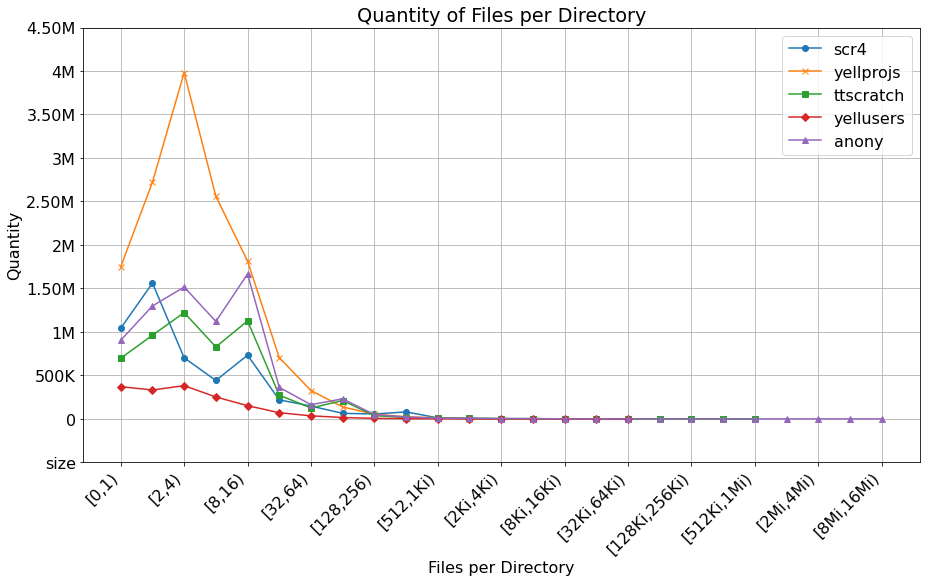

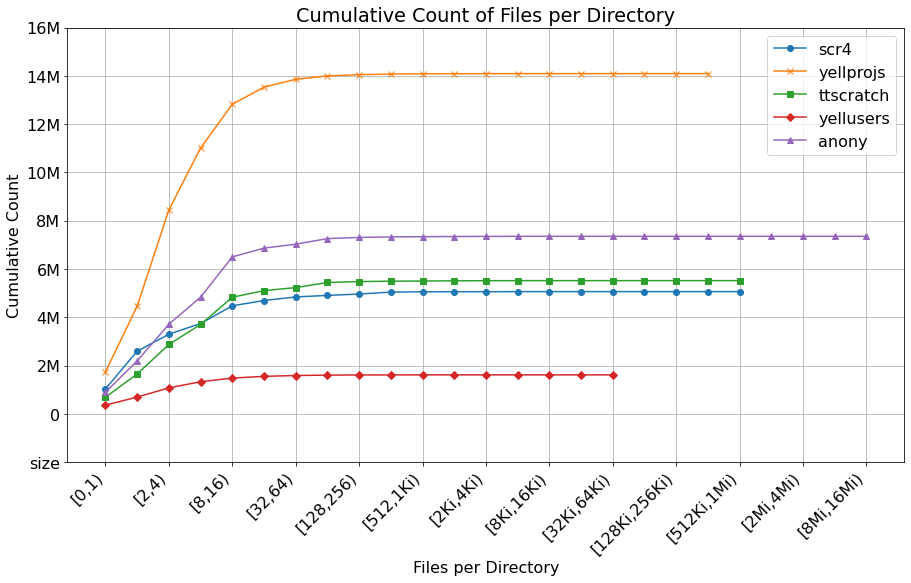

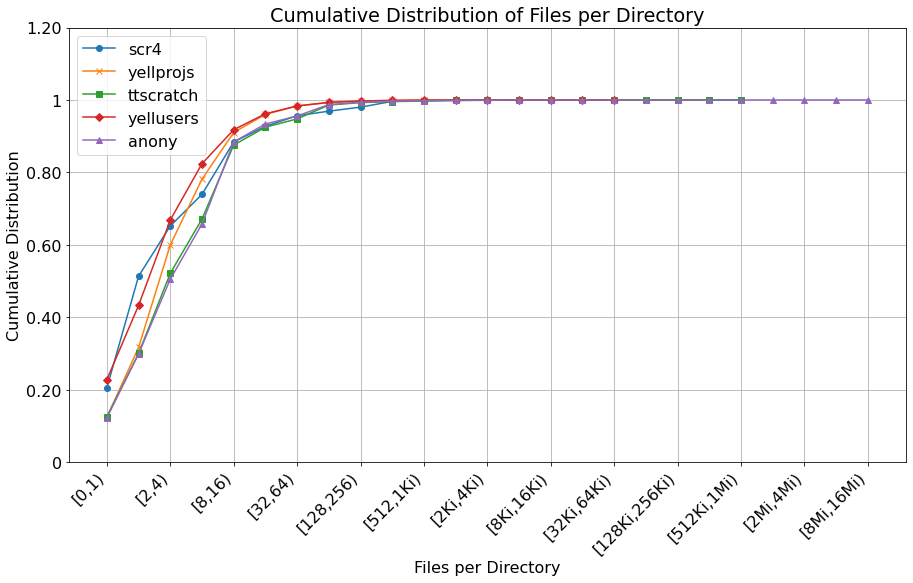

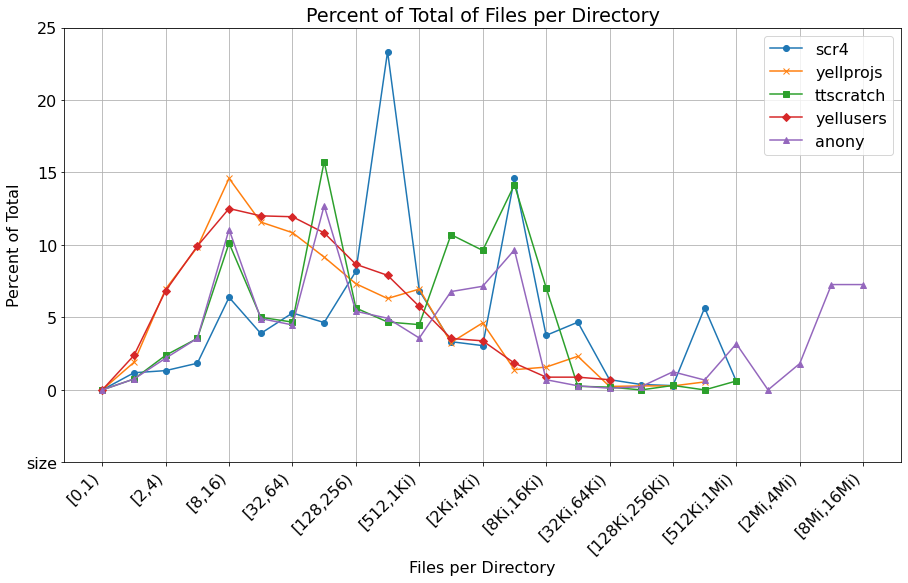

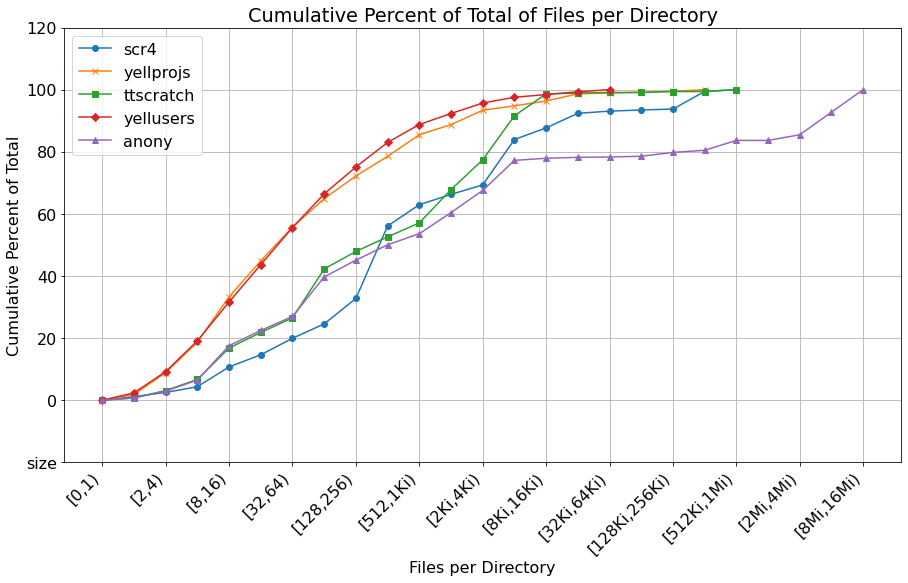

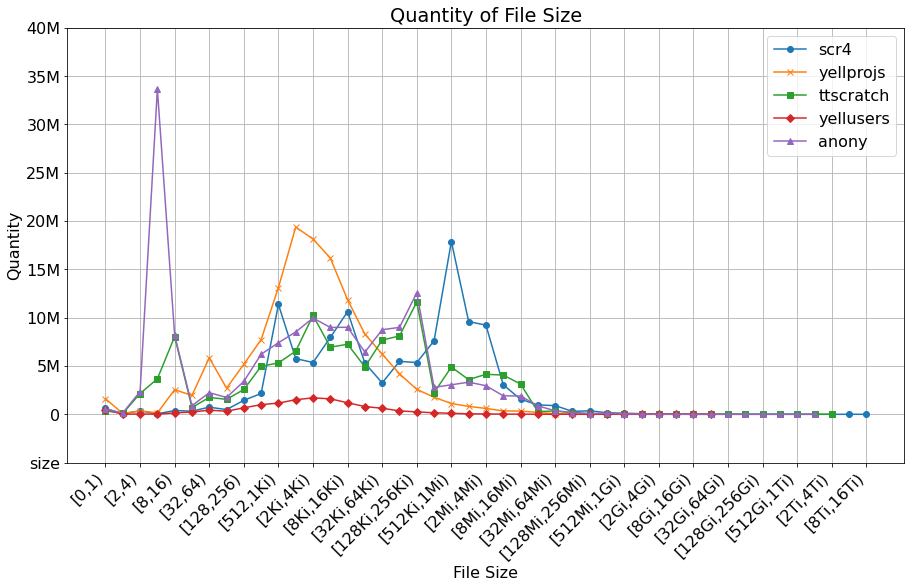

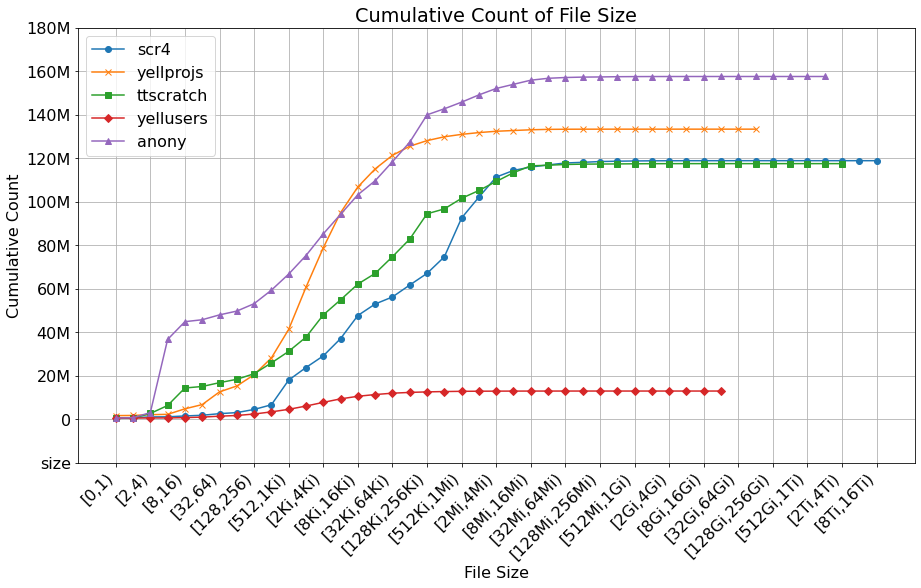

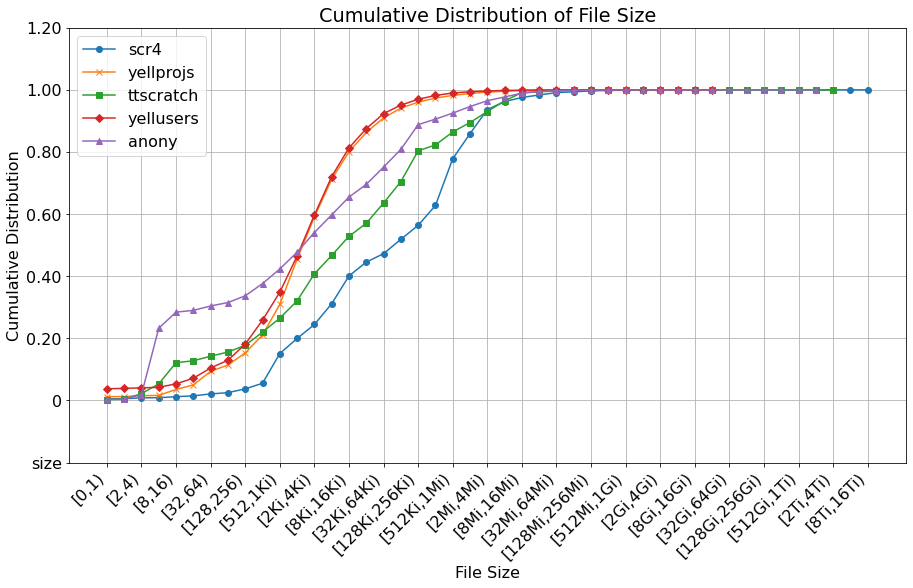

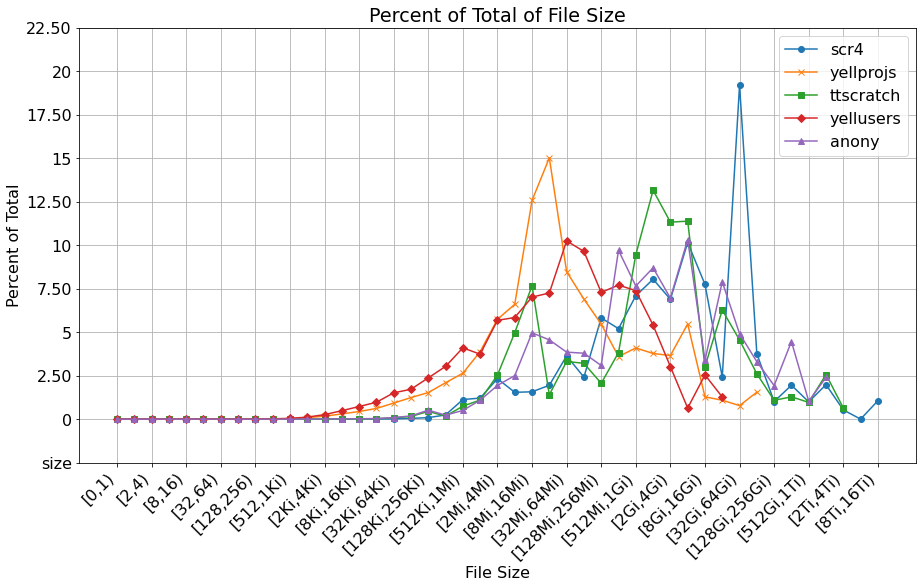

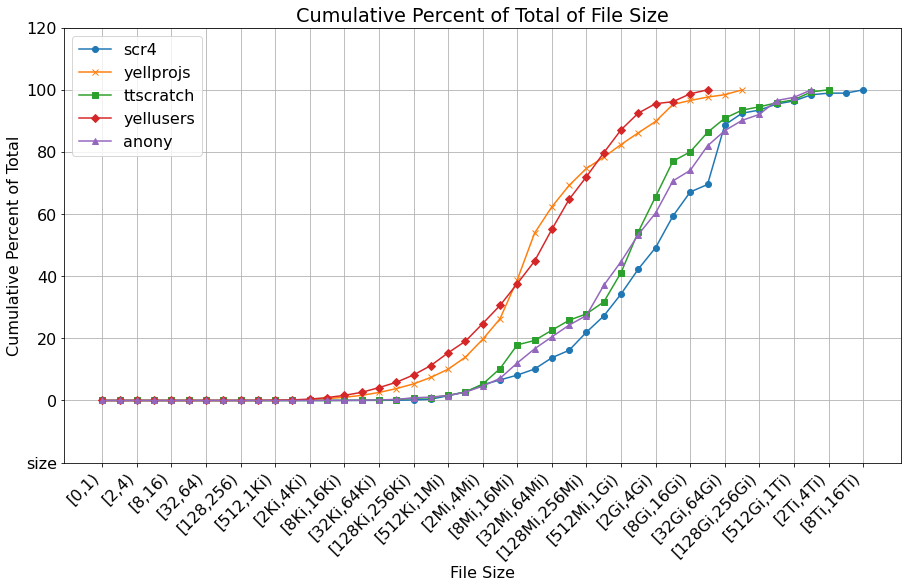

In [312]:
def make_graphs(all_data, field, xlabel):    
    dataframes = {}
    for ir,data in all_data[field].items():
        #print(f"Trying to convert {ir}:totfiles:\n{data} into a df")
        dataframes[ir] = convert_log_bins_to_dataframes(data)
    for graph in ('Quantity', 'Cumulative Count', 'Cumulative Distribution', 'Percent of Total', 'Cumulative Percent of Total'):
        plt = frames_to_plt(dataframes, xlabel=xlabel,yvalue=graph)
        plt.show()
    return dataframes
make_graphs(all_data,'totfiles','Files per Directory')
df = make_graphs(all_data,'size','File Size')

In [302]:
print(df['/mnt/nvme3n1/jbent/scr4/'])
pickle.dump(all_data, open("all_data.pkl", "wb")) # save in a pickle in case we lose the jupyter server

           Bucket  Quantity  Cumulative Count  Cumulative Distribution  \
0           [0,1)    605313            605313                 0.005093   
1           [1,2)     62518            667831                 0.005619   
2           [2,4)    346588           1014419                 0.008535   
3           [4,8)     49020           1063439                 0.008947   
4          [8,16)    388772           1452211                 0.012219   
5         [16,32)    323701           1775912                 0.014942   
6         [32,64)    736937           2512849                 0.021142   
7        [64,128)    484891           2997740                 0.025222   
8       [128,256)   1446053           4443793                 0.037389   
9       [256,512)   2151451           6595244                 0.055491   
10      [512,1Ki)  11363468          17958712                 0.151100   
11      [1Ki,2Ki)   5763647          23722359                 0.199594   
12      [2Ki,4Ki)   5356528          2

NameError: name 'pickle' is not defined

In [117]:
# a function to pull the predefined file size bins using the native gufi function
# note that this notebook is no longer using this function.
# also, we should be able to update it because totzero has been added in the following commit:
# https://github.com/mar-file-system/GUFI/commit/ed622831a0289876fd0b620c12a27db9043a152a
def get_predefined_bins(indexroot,Verbose=True):
    cmd = 'gufi_query'
    tab = 'vrsummary'
    itab = 'intermediate'
    atab = 'aggregate'
    fields = ('totltk', 'totmtk', 'totltm', 'totmtm', 'totmtg', 'totmtt', 'totzero')
    
    # int and agg use identical syntax for create so use helper function
    def create_table_str(table):
        create_str = ','.join([f"{field} INT64" for field in fields])
        return f"CREATE TABLE {table}({create_str});"
    
    # int and agg use identical syntax for insert so use helper function
    def insert_str(source,dest):
        select_str = ','.join([f"{field}" for field in fields])
        return f"INSERT INTO {dest} SELECT {select_str} from {source};"
    
    # create the string to select all the sums from the agg table
    agg_sum_str = ','.join([f"sum({field})" for field in fields])
    agg_select_str = f"SELECT {agg_sum_str} from {atab};"

    # now that we have all the strings constructed, we can run the command
    output = run_gufi_query(
        indexroot  = indexroot, 
        nthreads   = str(nthreads),
        create_int = create_table_str(itab),
        insert_int = insert_str(tab,itab),
        create_agg = create_table_str(atab),
        insert_agg = insert_str(itab,atab),
        select_agg = agg_select_str,
        Verbose    = Verbose
    )
    
    # convert the output into a dict corresponding to our fields
    out_dict = dict(zip(fields, map(int, output.split())))
    return out_dict

In [118]:
output = get_predefined_bins(indexroot,Verbose=True)
print(output)

GUFI query is 
   gufi_query
    -B 4096
    -I CREATE TABLE intermediate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64,totzero INT64);
    -S INSERT INTO intermediate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt,totzero from vrsummary;
    -K CREATE TABLE aggregate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64,totzero INT64);
    -J INSERT INTO aggregate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt,totzero from intermediate;
    -G SELECT sum(totltk),sum(totmtk),sum(totltm),sum(totmtm),sum(totmtg),sum(totmtt),sum(totzero) from aggregate;
    -n 224
    /mnt/nvme3n1/jbent/jbent_home
Output:
64801066817035113002226

Elapsed time: 0.00 minutes
{'totltk': 6480, 'totmtk': 10668, 'totltm': 17035, 'totmtm': 113, 'totmtg': 0, 'totmtt': 0, 'totzero': 2226}


In [119]:
def fill_bins(all_bins, indexroot, Verbose=True):
    if indexroot in all_bins:
        print(f"Cowardly refusing to overwrite an existing entry for {indexroot}")
    else:
        bins = get_predefined_bins(indexroot, Verbose)
        all_bins[indexroot] = bins

In [127]:
if 'all_prefilled_bins' not in locals():
    all_prefilled_bins = {}

indexroots = ["/mnt/nvme3n1/jbent/jbent_home/", 
              "/mnt/nvme3n1/jbent/scr4/", 
              "/mnt/nvme3n1/jbent/yellprojs/", 
              "/mnt/nvme3n1/jbent/ttscratch/", 
              "/mnt/nvme3n1/jbent/yellusers", 
              "/mnt/nvme3n1/jbent/anony"]

for ir in indexroots:
    fill_bins(all_prefilled_bins,ir,Verbose=True)

GUFI query is 
   gufi_query
    -B 4096
    -I CREATE TABLE intermediate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64,totzero INT64);
    -S INSERT INTO intermediate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt,totzero from vrsummary;
    -K CREATE TABLE aggregate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64,totzero INT64);
    -J INSERT INTO aggregate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt,totzero from intermediate;
    -G SELECT sum(totltk),sum(totmtk),sum(totltm),sum(totmtm),sum(totmtg),sum(totmtt),sum(totzero) from aggregate;
    -n 224
    /mnt/nvme3n1/jbent/jbent_home/
Output:
64801066817035113002226

Elapsed time: 0.00 minutes
GUFI query is 
   gufi_query
    -B 4096
    -I CREATE TABLE intermediate(totltk INT64,totmtk INT64,totltm INT64,totmtm INT64,totmtg INT64,totmtt INT64,totzero INT64);
    -S INSERT INTO intermediate SELECT totltk,totmtk,totltm,totmtm,totmtg,totmtt,totzero from vrsummary

In [135]:
# this function can convert the output from the prefilled bins into dataframes which then can be passed to plot
def convert_prefilled_bins_to_dataframe(prefilled_bins):
    bins=prefilled_bins
    ub = 'Bucket'
    nf = 'Num_Files'
    infinity = '\u221E'
    data = { ub : [], nf : []}
    tot = bins['totltk'] + bins['totmtk']
    data[ub].append('[0]')
    data[nf].append(bins['totzero'])
    data[ub].append('(0, 1K]')
    data[nf].append(bins['totltk'] - bins['totzero'])
    data[ub].append('(1K, 1M]')
    data[nf].append(bins['totmtk']-bins['totmtm'])
    data[ub].append('(1M, 1G]')
    data[nf].append(bins['totmtm'] - bins['totmtg'])
    data[ub].append('(1G, 1T]')
    data[nf].append(bins['totmtg'] - bins['totmtt'])
    data[ub].append(f'(1T, {infinity})')
    data[nf].append(bins['totmtt'])
    if tot != sum(data[nf]):
        print("Data error? Tot files of %d != tot files of %d" % (tot, sum(data[df])))
    return data

In [129]:
print(r'$\infty$')
print(all_prefilled_bins)

$\infty$
{'/mnt/nvme3n1/jbent/jbent_home/': {'totltk': 6480, 'totmtk': 10668, 'totltm': 17035, 'totmtm': 113, 'totmtg': 0, 'totmtt': 0, 'totzero': 2226}, '/mnt/nvme3n1/jbent/scr4/': {'totltk': 17964813, 'totmtk': 100888446, 'totltm': 92501443, 'totmtm': 26351816, 'totmtg': 122625, 'totmtt': 18, 'totzero': 605313}, '/mnt/nvme3n1/jbent/yellprojs/': {'totltk': 41297726, 'totmtk': 92058662, 'totltm': 130973511, 'totmtm': 2382877, 'totmtg': 1494, 'totmtt': 0, 'totzero': 1606000}, '/mnt/nvme3n1/jbent/ttscratch/': {'totltk': 31170081, 'totmtk': 86329960, 'totltm': 101556071, 'totmtm': 15943970, 'totmtg': 66100, 'totmtt': 9, 'totzero': 358526}, '/mnt/nvme3n1/jbent/yellusers': {'totltk': 4504208, 'totmtk': 8411792, 'totltm': 12788343, 'totmtm': 127657, 'totmtg': 91, 'totmtt': 0, 'totzero': 487872}, '/mnt/nvme3n1/jbent/anony': {'totltk': 66728128, 'totmtk': 90845161, 'totltm': 145782755, 'totmtm': 11790534, 'totmtg': 41322, 'totmtt': 7, 'totzero': 505352}}


In [136]:
dataframes = {}
for ir,bins in all_prefilled_bins.items():
    dataframes[ir] = convert_prefilled_bins_to_dataframe(bins)

In [137]:
dataframes

{'/mnt/nvme3n1/jbent/jbent_home/': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [2226, 4254, 10555, 113, 0, 0]},
 '/mnt/nvme3n1/jbent/scr4/': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [605313, 17359500, 74536630, 26229191, 122607, 18]},
 '/mnt/nvme3n1/jbent/yellprojs/': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [1606000, 39691726, 89675785, 2381383, 1494, 0]},
 '/mnt/nvme3n1/jbent/ttscratch/': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [358526, 30811555, 70385990, 15877870, 66091, 9]},
 '/mnt/nvme3n1/jbent/yellusers': {'Upper_Bound': ['[0]',
   '(0, 1K]',
   '(1K, 1M]',
   '(1M, 1G]',
   '(1G, 1T]',
   '(1T, ∞)'],
  'Num_Files': [487872, 4016336, 8284135, 127566, 91, 0]},
 '/mnt/nvme3n1/jbent/anony': {'Upper_Bo

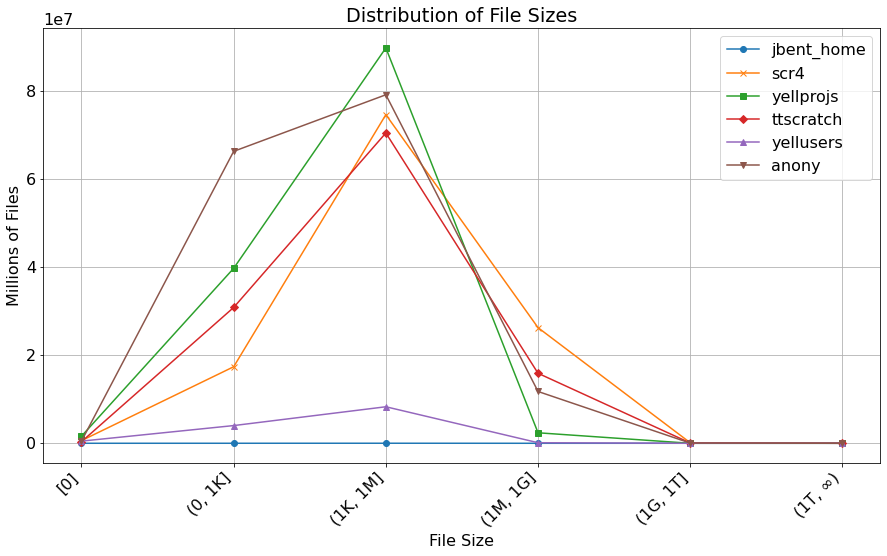

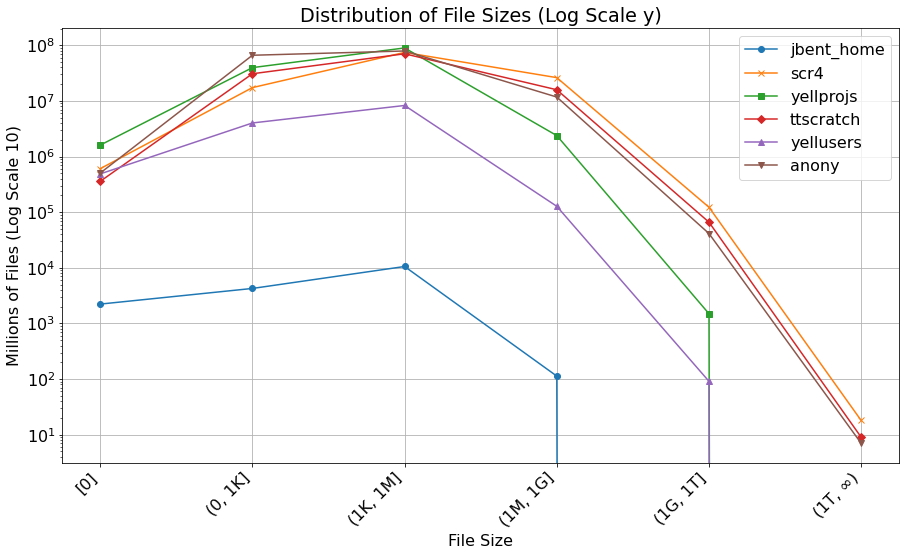

In [166]:
plt = frames_to_plt(dataframes)
plt.show()
plt2 = frames_to_plt(dataframes,logscale=True)
plt2.show()